In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../data/interim/train_clean.csv')
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductsInstalled,AVProductsEnabled,HasTpm,Platform,Processor,OsVer,OsSuite,...,AppVersion_encoded,Census_OSUILocaleIdentifier_encoded,EngineVersion_encoded,Census_OSInstallLanguageIdentifier_encoded,OrganizationIdentifier_encoded,Census_OSBranch_release_extracted_encoded,OsBuild_encoded,Census_ChassisTypeName_encoded,Census_OSEdition_encoded,Census_OSSkuName_encoded
0,win8defender,7.0,0,1.0,1.0,1,windows10,x64,10.0.0.0,256,...,0,0,0,0,1,0,0,2,1,1
1,win8defender,7.0,0,2.0,1.0,1,windows10,x64,10.0.0.0,768,...,1,0,1,0,1,0,0,1,0,0
2,win8defender,7.0,0,2.0,1.0,1,windows10,x64,10.0.0.0,256,...,0,4,0,4,1,0,0,1,1,1
3,win8defender,7.0,0,2.0,1.0,1,windows10,x64,10.0.0.0,768,...,11,1,1,20,0,8,4,0,2,2
4,win8defender,7.0,0,1.0,1.0,1,windows10,x64,10.0.0.0,256,...,0,19,1,19,0,0,0,0,7,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89214 entries, 0 to 89213
Data columns (total 66 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ProductName                                        89213 non-null  object 
 1   RtpStateBitfield                                   88878 non-null  float64
 2   IsSxsPassiveMode                                   89214 non-null  int64  
 3   AVProductsInstalled                                88849 non-null  float64
 4   AVProductsEnabled                                  88849 non-null  float64
 5   HasTpm                                             89214 non-null  int64  
 6   Platform                                           89214 non-null  object 
 7   Processor                                          89209 non-null  object 
 8   OsVer                                              89214 non-null  object 
 9   OsSuit

In [4]:
true_numerical_columns = ['Census_ProcessorCoreCount',
                 'Census_PrimaryDiskTotalCapacity',
                 'Census_SystemVolumeTotalCapacity',
                 'Census_TotalPhysicalRAM',
                 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                 'Census_InternalPrimaryDisplayResolutionHorizontal',
                 'Census_InternalPrimaryDisplayResolutionVertical',
                 'Census_InternalBatteryNumberOfCharges']
rank_columns = [col for col in df.columns if 'encoded' in col]
numerical_columns = true_numerical_columns + rank_columns

binary_columns = [col for col in df.columns.tolist() if df[col].nunique() <= 2 if df[col].dtypes != 'O']

categorical_columns = df.select_dtypes('object').columns.tolist()
cat_num_columns = [col for col in df.columns.tolist() if col not in numerical_columns
              if col not in binary_columns if col not in categorical_columns]
tot_columns = numerical_columns + binary_columns + categorical_columns + cat_num_columns
len(tot_columns)

66

In [5]:
z_score = np.abs(stats.zscore(df[true_numerical_columns], nan_policy='omit'))
z_score

array([[1.95567557e-04, 1.63606366e-01, 3.99296102e-01, ...,
        4.93509569e-01, 6.03828669e-01, 5.94314821e-01],
       [1.87710498e+00, 1.23653934e+00, 1.81227703e+00, ...,
        1.00046896e+00, 8.43017344e-01, 1.68261048e+00],
       [1.95567557e-04, 7.24369753e-02, 3.44106558e-01, ...,
        1.00046896e+00, 8.43017344e-01, 1.68261048e+00],
       ...,
       [1.95567557e-04, 1.23653934e+00, 3.24623671e-01, ...,
        1.37521075e-01, 8.29849010e-03, 1.68261048e+00],
       [1.95567557e-04, 1.23653934e+00, 2.89781873e-01, ...,
        4.93509569e-01, 6.03828669e-01,            nan],
       [1.95567557e-04, 1.23653934e+00, 8.21347786e-01, ...,
        1.00046896e+00, 8.43017344e-01, 5.94314821e-01]])

In [6]:
indices = df[true_numerical_columns][z_score > 3].index
indices

Int64Index([    1,     9,     9,     9,    26,    37,    50,    61,    61,
               74,
            ...
            89161, 89161, 89164, 89172, 89188, 89191, 89191, 89197, 89197,
            89208],
           dtype='int64', length=8238)

In [7]:
df_rmv_out = df.iloc[~df.index.isin(indices), :]
df_rmv_out.shape

(83934, 66)

In [8]:
# define function to create cdf dist plot
def cdf_dist_plots(df, columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    #fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    #fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        #ax = axes.flatten()[i]
        ax = sns.displot(data=df, x=col, hue='HasDetections', kind='ecdf')
        ax.set(xlabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

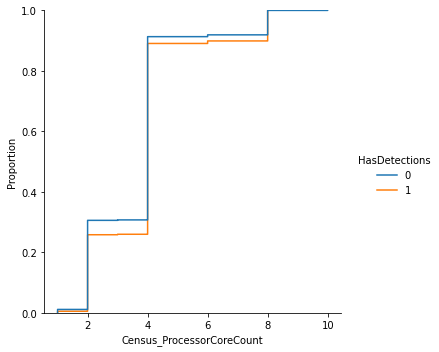

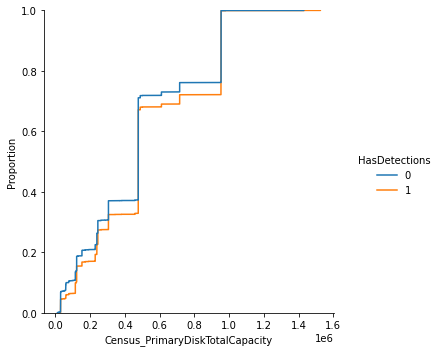

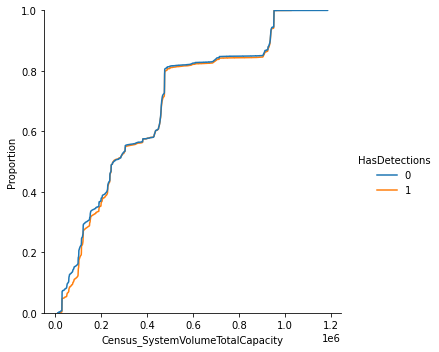

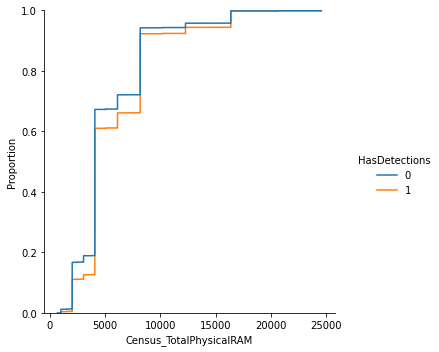

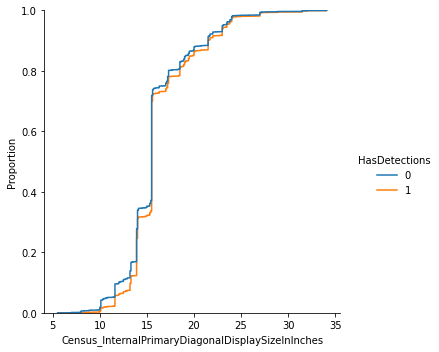

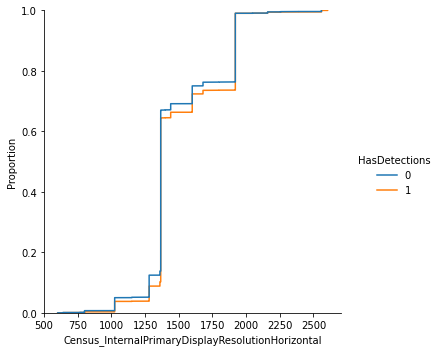

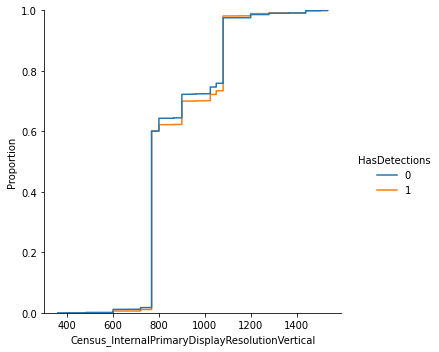

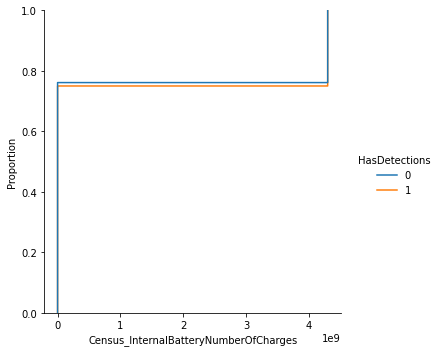

In [9]:
cdf_dist_plots(df_rmv_out, true_numerical_columns, figsize=(15, 15))

In [10]:
true_numerical_columns

['Census_ProcessorCoreCount',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges']

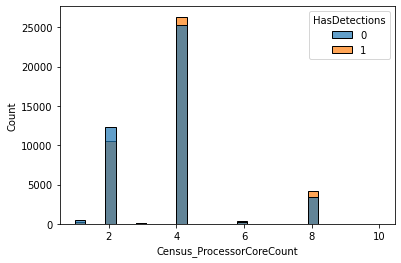

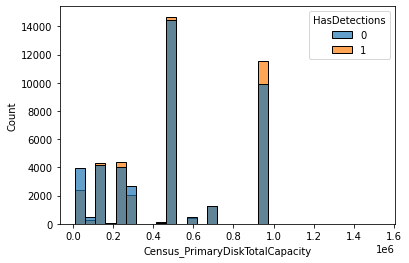

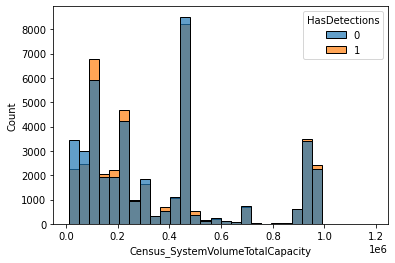

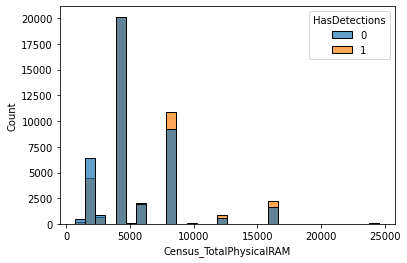

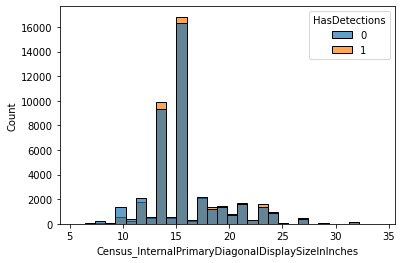

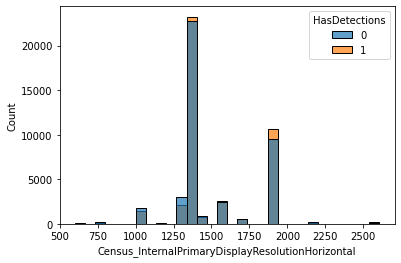

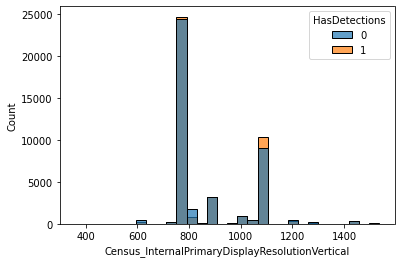

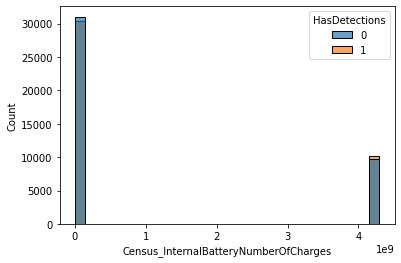

In [11]:
for col in true_numerical_columns:
    plt.figure()
    sns.histplot(x=col, hue='HasDetections', data=df_rmv_out, alpha=.7, bins=30)

In [12]:
cols = df[true_numerical_columns][z_score > 3].columns
df_out_nan = df.copy()

for col in cols:
    df_out_nan.loc[df.index.isin(indices), col] = np.nan

df_out_nan.shape

(89214, 66)

In [13]:
df_out_nan.isnull().mean().sort_values(ascending=False)

SmartScreen                              0.358733
Census_InternalBatteryNumberOfCharges    0.087991
Census_TotalPhysicalRAM                  0.067893
Census_SystemVolumeTotalCapacity         0.064867
Census_PrimaryDiskTotalCapacity          0.064867
                                           ...   
Census_IsSecureBootEnabled               0.000000
Census_IsTouchEnabled                    0.000000
Census_IsPenCapable                      0.000000
HasDetections                            0.000000
Census_OSSkuName_encoded                 0.000000
Length: 66, dtype: float64

In [14]:
df.isnull().mean().sort_values(ascending=False)

SmartScreen                              0.358733
Wdft_RegionIdentifier                    0.032954
Wdft_IsGamer                             0.032954
Census_InternalBatteryNumberOfCharges    0.030332
Firewall                                 0.010346
                                           ...   
Census_IsSecureBootEnabled               0.000000
Census_IsTouchEnabled                    0.000000
Census_IsPenCapable                      0.000000
HasDetections                            0.000000
Census_OSSkuName_encoded                 0.000000
Length: 66, dtype: float64